In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
#References from documentation
trans = torchvision.transforms.Compose([
    torchvision.transforms.RandAugment(),
    torchvision.transforms.Resize(size =(512,512)),
    ToTensor()
])
batchS = 70
data = torchvision.datasets.ImageFolder('../input/wild-animals/Wild_animals_512',transform = trans)
train_data,test_data = torch.utils.data.random_split(data,[round(data.__len__()*0.6),round(data.__len__()*0.4)])

#valid_data,testy_data = torch.utils.data.random_split(test_data,[round(test_data.__len__()*0.5),round(test_data.__len__()*0.5)])
valid_data,testy_data = torch.utils.data.random_split(test_data,[345,344])
train_load = DataLoader(train_data,shuffle = True,batch_size= batchS,drop_last=True)
valid_load = DataLoader(valid_data,shuffle = True,batch_size= batchS,drop_last = True)
test_load = DataLoader(testy_data,shuffle = True,batch_size= batchS,drop_last = True)
# print(len(test_load.dataset))

print('done')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done


In [4]:
#Neural Network referenced from  https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

#Initial Model code referenced from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
#Code from the 'Define the Network' section
#Experiment 1
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        #Feature extraction
        self.conv= nn.Conv2d(3,64,9)
        self.conv2 = nn.Conv2d(64,128,5)
        self.conv3 = nn.Conv2d(128,256,5)
        self.bat2d1 = nn.BatchNorm2d(64)
        self.bat2d2 = nn.BatchNorm2d(128)
        self.bat2d3 = nn.BatchNorm2d(256)
        self.bat1d = nn.BatchNorm1d(196)
        self.dropout = nn.Dropout(p= 0.5)

        
        #Classification layer
        self.lin = nn.Linear(921600,196)
        self.lin2 = nn.Linear(196,6)
        
    def forward(self,x):
        #First two lines are referenced
        x = F.max_pool2d(F.relu(self.conv(x)),(2,2))
        x=self.bat2d1(x)
        self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=self.bat2d2(x)
        self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        x=self.bat2d3(x)
        self.dropout(x)
        #print(x.shape)
        #Flattening tensors
        x = torch.flatten(x,1)
#         print(x.shape)
        x = F.relu(self.lin(x))
        self.bat1d(x)
        x = F.softmax(self.lin2(x),dim = 1)
        return x
    
model = Model()
device = torch.device("cuda:0")
#model.to(torch.device("cuda:0"))
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

model.to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001,weight_decay=0.000001)
lossfn = nn.CrossEntropyLoss()
lossx = 0
lossxt = 0

#count = []
lossgraph = []
testgraph = []
#Code referenced from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#I extracted data from the DataLoaders following the tutorial above
#I used two for loops and called the optimizer and loss functions in a similar way
#From the 'Define the network' section of the webpage.
for epoch in range(100):

    
    for i,data in enumerate(train_load, 0):
        lossx = 0
        pics, label = data
        pics, label = pics.cuda(), label.cuda()
        #print(pics.shape)
        optimizer.zero_grad()
        output = model(pics)
        #reshaping label
        #label = torch.tensor(label)
        labely = torch.zeros(batchS,6)
        for j in range(batchS):
            labely[j][label[j]] = 1
        #print(output)
        labely = labely.cuda()
        loss = lossfn(output,labely)
        #lossgraph.append(loss)
        loss.backward()
        lossx += loss
        #print(output)
        optimizer.step()
        #graphing loss
        
        #print(len(lossgraph),epoch,i)
    lossgraph.append(lossx.item())

    testingloss = nn.CrossEntropyLoss()
#     classes = {0:'Motorbikes',1:'Airplanes',2:'Schooner'}
    total = 0
    correct = 0
    for i, data in enumerate(valid_load,0):
        lossxt = 0
        pics,label = data
        pics, label = pics.cuda(), label.cuda()
        #print(pics.shape)
        output = model(pics)
        labely = torch.zeros(batchS,6)
        for j in range(batchS):
            labely[j][label[j]] = 1
            #print(output)
        labely = labely.cuda()
        loss = testingloss(output,labely)
        lossxt += loss.item()
        #print(output)
        maxele,maxindx = torch.max(output,1)
        for j in range(batchS):
            #print('Prediction: {0}, Answer: {1}'.format(classes[maxindx[j].item()],classes[label[j].item()]))
            #print(maxindx[j].item(),label[j].item())
            if(torch.eq(maxindx[j],label[j])):
                correct = correct +1
            total = total+1
    #print(correct,total)
    
    #plt.legend('Training set','Validation set')
    accuracy = (correct/total)*100
    #print('Accuracy is {0:.2f}%'.format(accuracy))
    testgraph.append(lossxt)

        #plt.ylim(4e-1,7e-1)
#plt.yscale('log')
#plt.figure(figsize = (1,1))
#print(testgraph)

#plt.yscale('log')



torch.cuda.empty_cache()
        
        
    



    
#for epoch,data in enumerate(train_load,0):
    #inputy, label= data
    #forward(inputy)
#ask how to get gradient of linear stuff and how to determine convolutions

Let's use 2 GPUs!


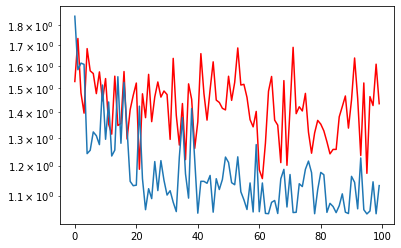

In [5]:
plt.yscale('log')
plt.plot(testgraph,'r-')
plt.plot(lossgraph)

In [6]:
#validation cell
#Code referenced from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#I extracted data from the DataLoaders following the tutorial above
#I used two for loops and called the optimizer and loss functions in a similar way
#From the 'Define the network' section of the webpage.
'''

'''
#testgraph = []
#testingloss = nn.CrossEntropyLoss()
classes = {0:'Motorbikes',1:'Airplanes',2:'Schooner'}
total = 0
correct = 0
cl = []
pl = []
for i, data in enumerate(valid_load,0):
    lossxt = 0
    pics,label = data
    pics, label = pics.cuda(), label.cuda()
    #print(pics.shape)
    output = model(pics)
    labely = torch.zeros(batchS,6)
    for j in range(batchS):
        labely[j][label[j]] = 1
        #print(output)
    labely = labely.cuda()
    #loss = testingloss(output,labely)
    #lossxt += loss.item()
    #print(output)
    maxele,maxindx = torch.max(output,1)
    #testgraph.append(lossxt)
    for j in range(batchS):
        #print('Prediction: {0}, Answer: {1}'.format(classes[maxindx[j].item()],classes[label[j].item()]))
        #print(maxindx[j].item(),label[j].item())
        cl.append(label[j].item())
        pl.append(maxindx[j].item())
        if(torch.eq(maxindx[j],label[j])):
            correct = correct +1
        total = total+1
print(correct,total)
#plt.plot(testgraph)
#plt.legend('Training set','Validation set')
accuracy = (correct/total)*100
fscore = f1_score(cl,pl,average='macro')
print("F1 score is {0:.2f}".format(fscore))
print('Accuracy is {0:.2f}%'.format(accuracy))
    

222 340
F1 score is 0.65
Accuracy is 65.29%


In [ ]:
#Testing data
#Code referenced from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#I extracted data from the DataLoaders following the tutorial above
#I used two for loops and called the optimizer and loss functions in a similar way.
#From the 'Define the network' section of the webpage.
total = 0
correct =0
cl2 = []
pl2 = []
for i2, data2 in enumerate(test_load,0):
    #lossxt = 0
    pics,label = data2
    pics, label = pics.cuda(), label.cuda()
    #print(pics.shape)
    output = model(pics)
    labely = torch.zeros(batchS,3)
    for j in range(batchS):
        labely[j][label[j]] = 1
        #print(output)
    labely = labely.cuda()
    loss = testingloss(output,labely)
    #lossxt += loss
    #print(output)
    maxele,maxindx = torch.max(output,1)
    #testgraph.append(lossxt)
    for j in range(batchS):
        #print('Prediction: {0}, Answer: {1}'.format(classes[maxindx[j].item()],classes[label[j].item()]))
        #print(maxindx[j].item(),label[j].item())
        cl2.append(label[j].item())
        pl2.append(maxindx[j].item())
        if(torch.eq(maxindx[j],label[j])):
            correct = correct +1
        total = total+1
print(correct,total)
#plt.plot(testgraph)
accuracy = (correct/total)*100
fscore = f1_score(cl2,pl2,average='macro')
print("F1 score is {0:.2f}".format(fscore))
print('Accuracy is {0:.2f}%'.format(accuracy))


# KNN model
I am utilizing the knn method of classification on these images by first putting on the images and their labels into seperate list. I will then put these list into sklearn's knn function.

In [ ]:
images  = []
labs = []
for l, stuff in enumerate(train_load,0):
    theStuff, la = stuff
    theStuff = torch.flatten(theStuff,1)
    images.append(theStuff)
    labs.append(la)
print(len(images),len(labs))
    